# Data-driven computational mechanics solver for truss structures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ddtruss import Truss, DataDrivenSolver

params = {"axes.titlesize": 14,
          "axes.labelsize": 14,
          "font.size": 14,
          "xtick.labelsize": 14,
          "ytick.labelsize": 14,
          "legend.fontsize": 14,
          "savefig.bbox": "tight"}
plt.rcParams.update(params)

%matplotlib inline

In [2]:
def rms_error(ref, curr):
    return np.sqrt(truss.integrate((ref - curr)**2) / truss.integrate(ref**2))

def plot(eps, sig, ddsolver=None, f_obj_iter=None, plot_truss=True):
    if f_obj_iter is not None and plot_truss:
        fig, ax = plt.subplots(1, 3, figsize=(18, 4))
        ax_truss = ax[0]
        ax_material = ax[1]
        ax_iter = ax[2]
    elif f_obj_iter is None and not plot_truss:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax_material = ax
    else:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        if plot_truss:
            ax_truss = ax[0]
            ax_material = ax[1]
        else:
            ax_material = ax[0]
            ax_iter = ax[1]
    
    if plot_truss:
        truss.plot(ax=ax_truss, u=u, eps=eps)
    
    ax_material.plot(eps, sig, "C1x", label="numerical")
    f_obj = None
    if ddsolver is not None:
        idx, *_ = ddsolver._optimal_local_states(np.hstack([eps.reshape((-1, 1)), sig.reshape((-1, 1))]))
        eps_sig_ = material_data[idx]
        ax_material.plot(material_data[:, 0], material_data[:, 1], "C0.", label="data")
        for i in range(len(eps)):
            ax_material.plot([eps[i], eps_sig_[i, 0]], [sig[i], eps_sig_[i, 1]], "k-", alpha=0.5)
    
    ax_material.set_xlabel(r"$\varepsilon$")
    ax_material.set_ylabel(r"$\sigma$")
    ax_material.grid()
    ax_material.legend()
    
    if f_obj_iter is not None:
        ax_iter.semilogy(f_obj_iter, "-o")
        ax_iter.set_xlabel("iteration")
        ax_iter.set_ylabel("$f_\mathrm{obj}$")
        ax_iter.grid()
        ax_iter.set_title(f"{len(f_obj_iter) - 1:d} iterations")
    
    fig.tight_layout()
    return fig, ax

# 1-d examples

Consider a single bar composed of two node points $A=(0, 0)$ and $B=(1, 0)$. The left point is fixed and we prescribe to the bar either a
- a soft device, by applying a force $F_x=1$ on $B$ and fixing $u_y=0$ on $B$
- a hard device, by applying $u=U=(1, 0)$ for $B$.

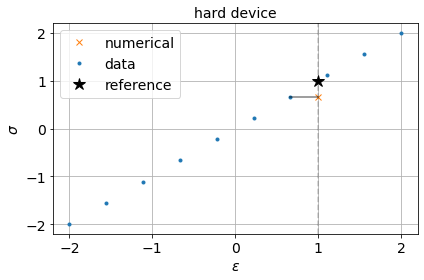

In [4]:
# Truss definition
points = np.array([
    [0, 0],
    [1, 0],
])
lines = np.array([
    [0, 1],
], dtype=int)
truss = Truss(points, lines)

device = "hard"
if device == "soft":
    U_dict = {0: [0, 0], 1: [None, 0]}
    F_dict = {1: [1, 0]}
else:
    U_dict = {0: [0, 0], 1: [1, 0]}
    F_dict = {}

# Find the reference solution corresponding to E = 1
E = 1
u, eps_ref, sig_ref = truss.solve(E=E, U_dict=U_dict, F_dict=F_dict)

# Define the data-driven solver
ddsolver = DataDrivenSolver(truss)

# Generate and load a sample material data set
eps_data = np.linspace(-2, 2, 10)
sig_data = E * eps_data
material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
ddsolver.load_material_data(material_data)

# Solve the data-driven problem
u, eps, sig, f_obj_iter = ddsolver.solve(U_dict=U_dict, F_dict=F_dict)
plot(eps, sig, ddsolver, plot_truss=False)
plt.plot(eps_ref, sig_ref, "k*", markersize=12, label="reference")
if device == "soft":
    plt.axhline(1, color="k", linestyle="--", alpha=0.2)
else:
    plt.axvline(1, color="k", linestyle="--", alpha=0.2)
plt.legend()
plt.title(f"{device} device")
plt.tight_layout()

# 2-d problem

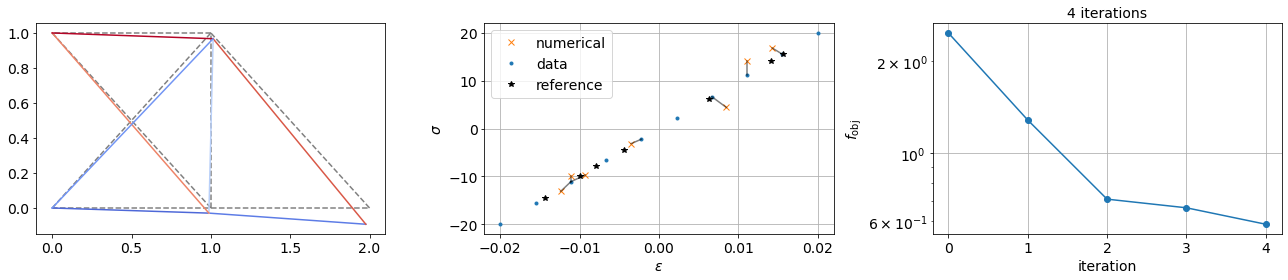

In [22]:
points = np.array([
    [0, 0],
    [1, 0],
    [2, 0],
    [1, 1],
    [0, 1],
])
lines = np.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [1, 3],
    [1, 4],
    [3, 4],
    [0, 3],
], dtype=int)

truss = Truss(points, lines)

E = 1e3
U_dict = {0: [0, 0], 4: [0, 0]}
F_dict = {2: [0, -10]}

u, eps_ref, sig_ref = truss.solve(E=E, U_dict=U_dict, F_dict=F_dict)

ddsolver = DataDrivenSolver(truss)

eps_data = np.linspace(-0.02, 0.02, 10)
sig_data = E * eps_data
material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
ddsolver.load_material_data(material_data)

u, eps, sig, f_obj_iter = ddsolver.solve(U_dict=U_dict, F_dict=F_dict)
fig, ax = plot(eps, sig, ddsolver, f_obj_iter)
ax[1].plot(eps_ref, sig_ref, "k*", label="reference")
ax[1].legend()
fig.tight_layout()

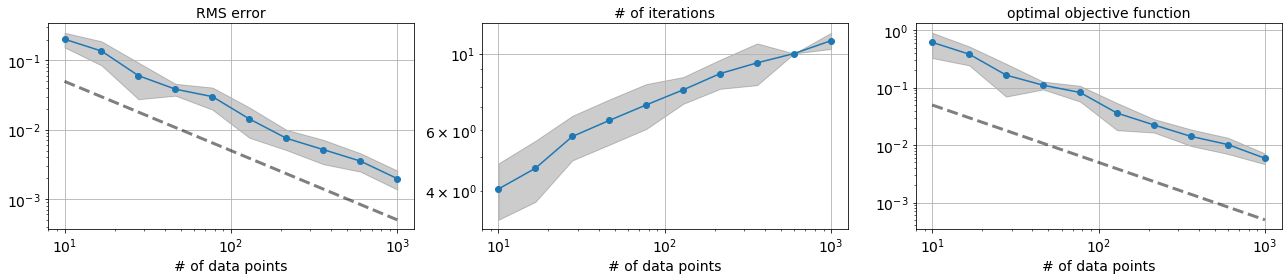

In [6]:
n_runs = 20
n_data = np.logspace(1, 3, 10)
error_eps = np.zeros((n_runs, len(n_data)))
n_iterations = np.zeros((n_runs, len(n_data)))
f_obj = np.zeros((n_runs, len(n_data)))

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

for i_run in range(n_runs):
    for i_data in range(len(n_data)):
        eps_data = np.linspace(-0.02, 0.02, n_data[i_data])
        sig_data = E * eps_data
        material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
        ddsolver.load_material_data(material_data)
        u, eps, sig, f_obj_iter = ddsolver.solve(U_dict=U_dict, F_dict=F_dict)
        error_eps[i_run, i_data] = rms_error(eps_ref, eps)
        n_iterations[i_run, i_data] = len(f_obj_iter)
        f_obj[i_run, i_data] = f_obj_iter[-1]

def subplot(ax, data, title):
    mean = data.mean(axis=0)
    ax.loglog(n_data, mean, "-o")
    std = data.std(axis=0)
    ax.fill_between(n_data, mean - 1.96 * std, mean + 1.96 * std, color="k", alpha=0.2)
    ax.set_xlabel("# of data points")
    ax.set_title(title)
    ax.grid()

subplot(ax[0], error_eps, "RMS error")
ax[0].loglog(n_data, 0.5 / n_data, "k--", linewidth=3, alpha=0.5)

subplot(ax[1], n_iterations, "# of iterations")
subplot(ax[2], f_obj, "optimal objective function")
ax[2].loglog(n_data, 0.5 / n_data, "k--", linewidth=3, alpha=0.5)

fig.tight_layout()

# Noisy data

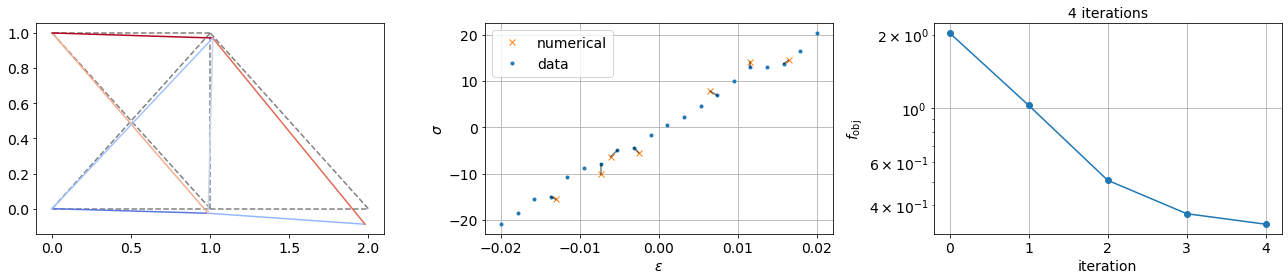

In [20]:
n_data = 20
eps_data = np.linspace(-0.02, 0.02, n_data)
sig_data = E * (eps_data + 0.05 * eps_data.max() * np.random.randn(n_data))
material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
ddsolver.load_material_data(material_data)

u, eps, sig, f_obj_iter = ddsolver.solve(U_dict=U_dict, F_dict=F_dict)
plot(eps, sig, ddsolver, f_obj_iter);

# Nonlinear behavior

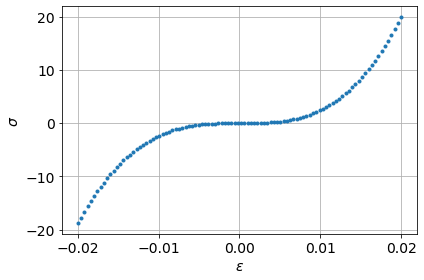

In [14]:
n_data = 100
eps_data = np.linspace(-0.02, 0.02, n_data)
A = 20 / (np.exp(0.02) - 1)**3
sig_data = A * (np.exp(eps_data) - 1)**3
plt.plot(eps_data, sig_data, ".")
plt.grid()
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$\sigma$")
plt.tight_layout()

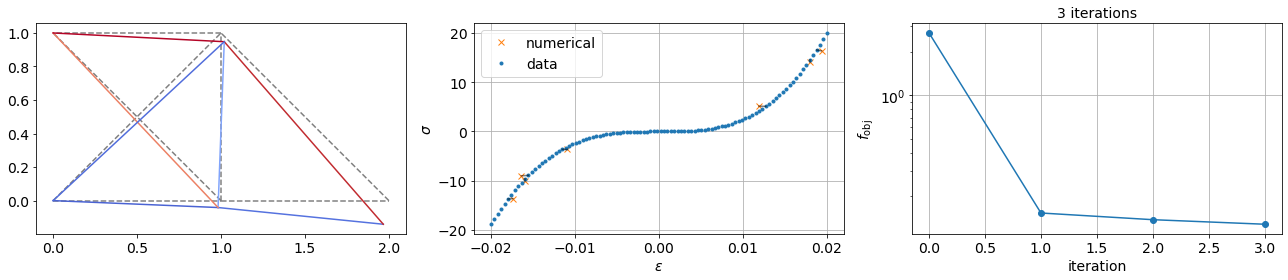

In [18]:
material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
ddsolver.load_material_data(material_data)

u, eps, sig, f_obj_iter = ddsolver.solve(U_dict=U_dict, F_dict=F_dict)
plot(eps, sig, ddsolver, f_obj_iter);